In [114]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [115]:
def load_data(data_path=''):
    train = os.path.join(data_path, "train.csv")
    test = os.path.join(data_path, "test.csv")
    return pd.read_csv(train), pd.read_csv(test)

In [116]:
train_df, test_df = load_data()

In [117]:
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


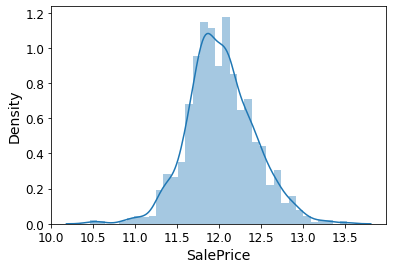

In [118]:
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
sns.distplot(train_df['SalePrice']);

In [119]:
def prep_to_submit(ids, preds, fname='submission.csv'):
    preds = np.expm1(preds)
    preds = pd.DataFrame({'Id': ids, 'SalePrice': preds})
    preds.to_csv(fname, index=False)

In [120]:
# Drop Id column, and the target variable

train = train_df.drop('Id', axis=1)

test_ids = test_df['Id'].copy()
test = test_df.drop('Id', axis=1)

#### Type of features



num_attribs = train.select_dtypes([np.number]).columns

cat_attribs = train.select_dtypes(include=[np.object]).columns

print('numerical:{} \n\n categorical:{}'.format(num_attribs, cat_attribs))

numerical:Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object') 

 categorical:Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',


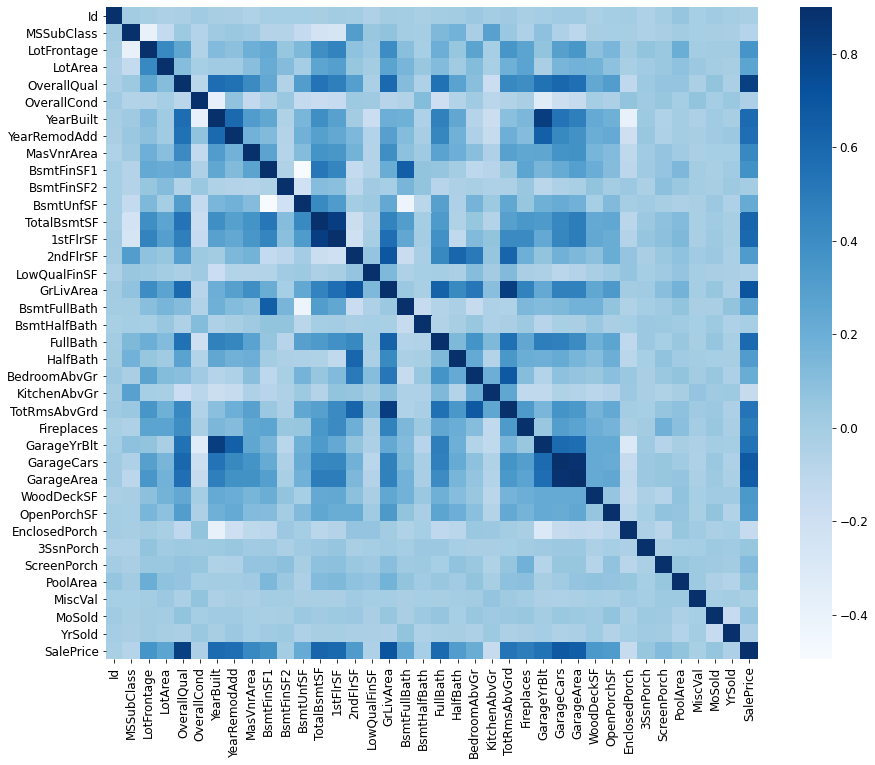

In [121]:
corrmat = train_df.corr()
plt.subplots(figsize=(15,12));
sns.heatmap(corrmat, vmax=0.9, cmap="Blues", square=True);

In [122]:
corrmat['SalePrice'].sort_values(ascending=False)[:10]

SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
Name: SalePrice, dtype: float64

Let's investigate highly correlated features

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


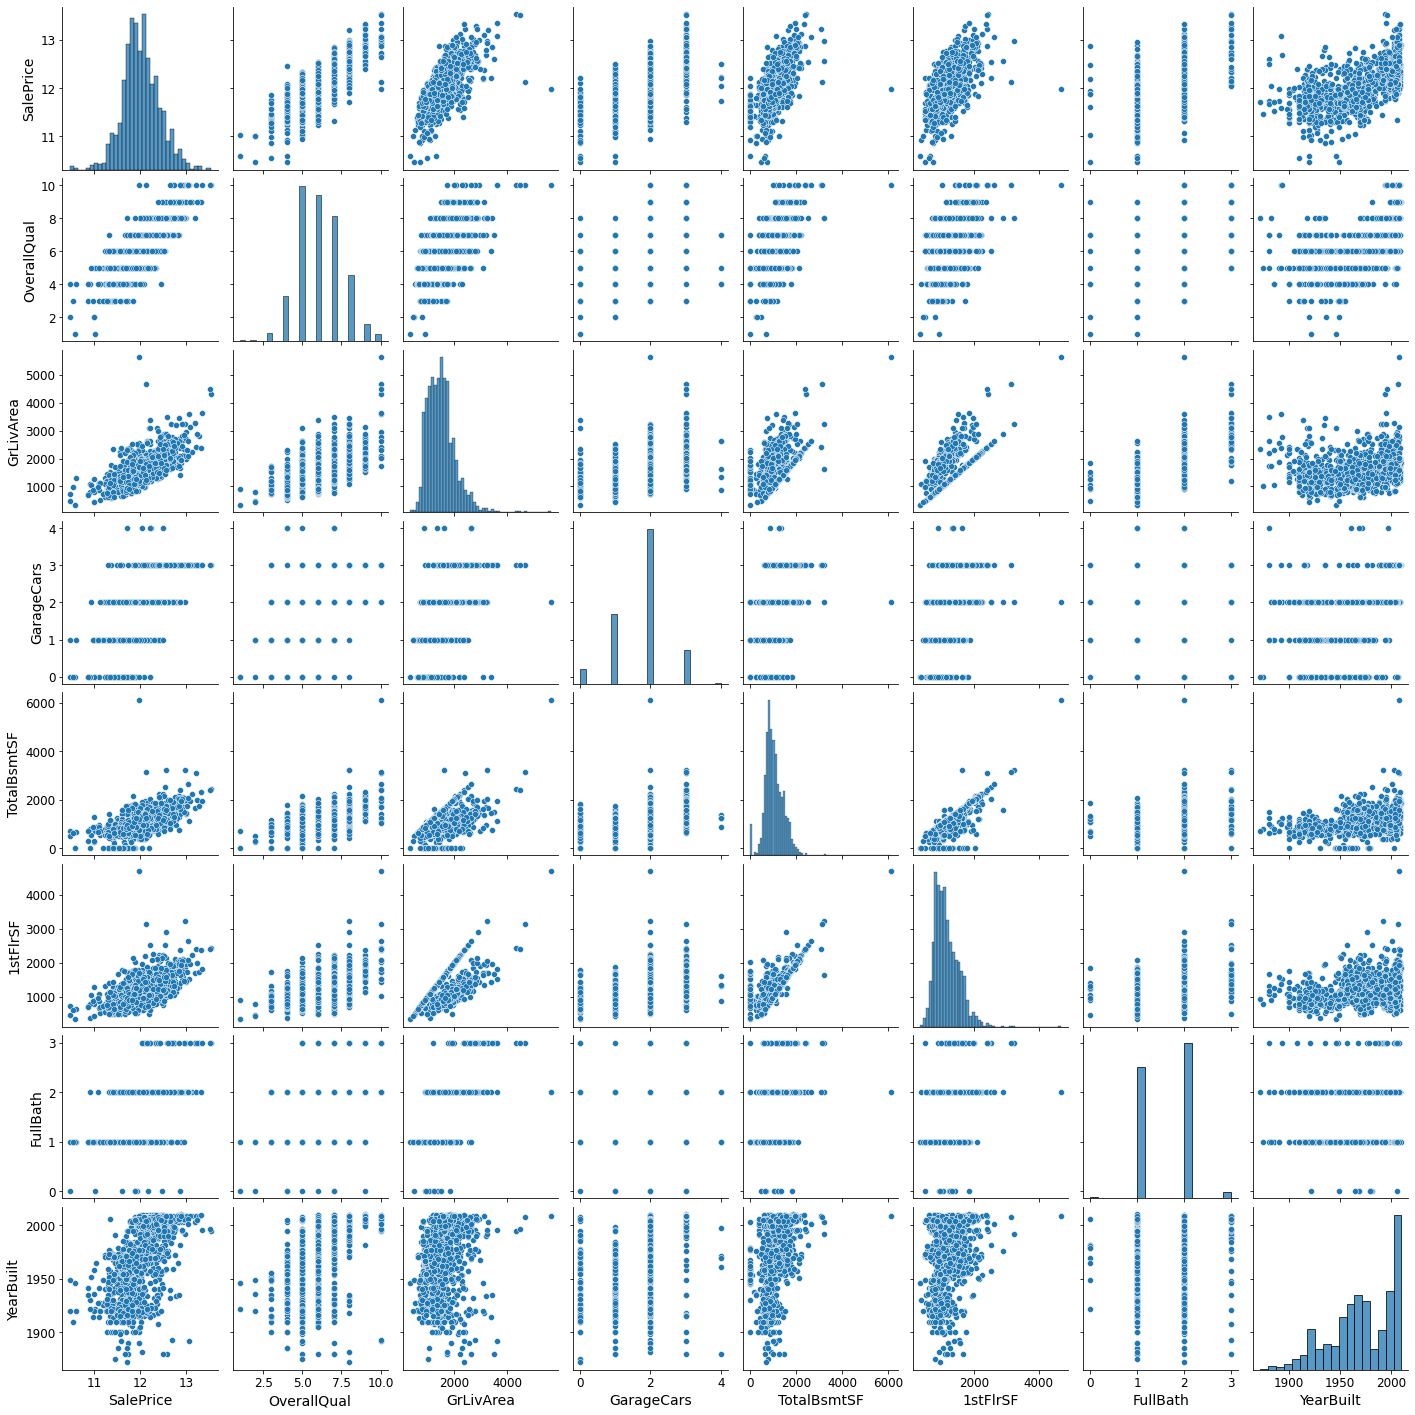

In [123]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_df[cols], size = 2.5)
plt.show();

- There are 2 data points in GrLiveArea vs Sale Price that looks like an outlier
- There is also another data point in TotalBsmtSF vs Sale price taht looks like an outlier

Lets deal with these

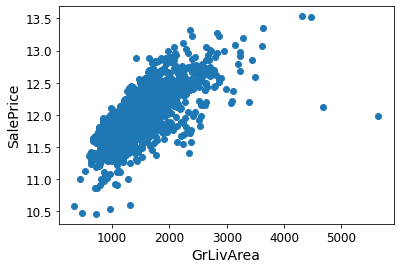

In [124]:
plt.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.show()

lets drop those 2 examples that looks a lot like outliers

In [125]:
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<12.5)].index)

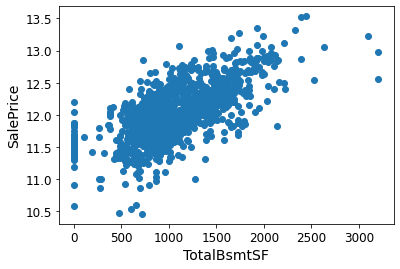

In [126]:
plt.scatter(x = train_df['TotalBsmtSF'], y = train_df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('TotalBsmtSF')
plt.show()

That data point looked like an outlier to TotalBsmtSF was the same point we just dropped - so we are good

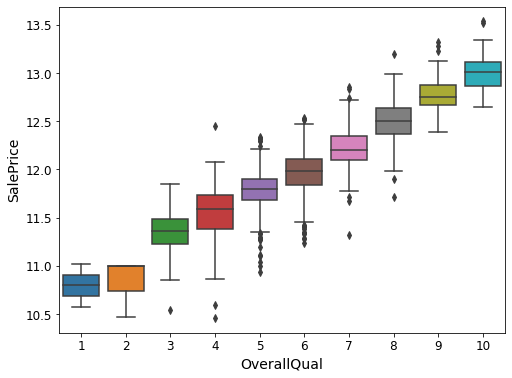

In [127]:
# feature OverallQual
plt.subplots(figsize=(8, 6))
sns.boxplot(x=train_df['OverallQual'], y=train_df["SalePrice"])

Lets treat this as a category rather than a numerical value

In [128]:
train_df['OverallCond'] = train_df['OverallCond'].astype(str)
test_df['OverallCond'] = test_df['OverallCond'].astype(str)

In [129]:
train = train_df.copy()
test = test_df.copy()

In [130]:
cat_attribs = train.select_dtypes(include=[np.object]).columns
train[cat_attribs].describe(include='all')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1458,1458,91,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1450,1458,1458,1458,1421,1421,1420,1421,1420,1458,1458,1458,1457,1458,1458,768,1377,1377,1377,1377,1458,6,281,54,1458,1458
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,9,6,7,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Fa,MnPrv,Shed,WD,Normal
freq,1149,1452,50,925,1311,1457,1051,1380,225,1260,1444,1218,726,819,1141,1433,515,504,864,906,1280,645,649,1309,953,430,1254,1426,739,1363,1332,735,1358,378,869,605,1309,1324,1338,2,157,49,1267,1198


In [131]:
train['Street'].value_counts()

Pave    1452
Grvl       6
Name: Street, dtype: int64

In [132]:
train['Utilities'].value_counts()

AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64

lets drop the above two categorical features, there is no variation no information here to learn from

In [133]:
train.drop(columns=['Utilities', 'Street'], inplace=True)
test.drop(columns=['Utilities', 'Street'], inplace=True)

In [134]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageCond,81,0.055556
GarageType,81,0.055556
GarageYrBlt,81,0.055556
GarageFinish,81,0.055556


### Handling missing values

In [137]:
#From: got ideas from https://www.kaggle.com/niteshx2/top-50-beginners-stacking-lgb-xgb

def fix_nas(df):
    #Fill na for these column with standard equipment for those - intuition from data description.txt
    df['Functional'] = df['Functional'].fillna('Typ') 
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['KitchenQual'] = df['KitchenQual'].fillna('TA')
    df['SaleType'] = df['SaleType'].fillna('Other')
    df['Exterior1st'] = df['Exterior1st'].fillna('Other')
    df['Exterior2nd'] = df['Exterior2nd'].fillna('Other')
    
    #None for not exists - intuition from data description.txt
    df['PoolQC'] = df['PoolQC'].fillna('None')
    
    #These two are probably very related
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    #Na means No Garage
    for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
        df[col] = df[col].fillna(0)
    
    #Na means No Garage 
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        df[col] = df[col].fillna('None')
    
    #Na means there's no basement
    for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        df[col] = df[col].fillna('None')
    
    #Na means no basement, so the measurement is 0
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)
        
    for col in df.select_dtypes(include=[np.object]).columns:
        df[col] = df[col].fillna('None')
        
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(0)
    
    return df

In [138]:
train = fix_nas(train)
test = fix_nas(test)

### Feature Engineering

In [139]:
def combine_features(df):
    
    # Exists or not
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['Has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    #Unfinished or not
    df['BsmtFinType1_Unf'] = 1*(df['BsmtFinType1'] == 'Unf')
    
    df['OldHouse'] = df['YearBuilt'].apply(lambda x: 1 if x <1990 else 0)
    
    #Some aggregated features
    df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                            df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                          df['EnclosedPorch'] + df['ScreenPorch'] +
                          df['WoodDeckSF'])
    
    
  
    df['Age_YrBuilt'] = df['YrSold'] - df['YearBuilt']
    df['Age_YrRemod'] = df['YrSold'] - df['YearRemodAdd']
    df['Age_Garage'] = df['YrSold'] - df['GarageYrBlt']
    df['Remodeled'] = df['YearBuilt']!=df['YearRemodAdd']

    #to fix if the garageyrbuilt is 0 for example - its 0 if garage was never built
    df['Age_YrBuilt'] = df['Age_YrBuilt'].apply(lambda x: 0 if x <0 else x)
    df['Age_YrRemod'] = df['Age_YrRemod'].apply(lambda x: 0 if x <0 else x)
    df['Age_Garage'] = df['Age_Garage'].apply(lambda x: 0 if x <0 else x)
        
    
    return df

In [140]:
train = combine_features(train)
test = combine_features(test)

In [141]:
# From the description of data MSSubClass looks like a categorical value
train[['MSSubClass', 'YrSold', 'MoSold']] = train[['MSSubClass', 'YrSold', 'MoSold']].astype(str)
test[['MSSubClass', 'YrSold', 'MoSold']] = test[['MSSubClass', 'YrSold', 'MoSold']].astype(str) 

In [142]:
# corrmat = train.corr()
# corrmat['SalePrice'].sort_values(ascending=False)[:25]

In [143]:
# corrmat['SalePrice'].sort_values(ascending=True)[:25]

In [144]:
#Lets drop the two least correlated features
train.drop(columns=['BsmtFinSF2', 'BsmtHalfBath'], inplace=True)
test.drop(columns=['BsmtFinSF2', 'BsmtHalfBath'], inplace=True)

In [145]:

train['MSSubClass'] = train['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

#### Type of features
num_attribs = train.select_dtypes([np.number]).columns

# ord_attribs = list(['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
#         'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
#         'BsmtFinType2', 'Functional', 'GarageFinish', 'LandSlope', 'YrSold', 'MoSold'])

cat_attribs = train.select_dtypes(include=[np.object]).columns

print('numerical:{} \n\n categorical:{}'.format(num_attribs, cat_attribs))

numerical:Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'SalePrice', 'HasPool', 'Has2ndfloor', 'HasGarage',
       'HasBsmt', 'HasFireplace', 'BsmtFinType1_Unf', 'OldHouse', 'TotalSF',
       'TotalBathrooms', 'TotalPorchSF', 'Age_YrBuilt', 'Age_YrRemod',
       'Age_Garage'],
      dtype='object') 

 categorical:Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd',

### Model selection

In [146]:
for feat in cat_attribs:
  train[feat] = train[feat].astype(str)
  test[feat] = test[feat].astype(str)

In [147]:
all_y = train["SalePrice"].copy()
all_X = train.copy()
all_X.drop('SalePrice', axis=1, inplace=True)


In [148]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(all_X, all_y, test_size=0.2, random_state=42)

In [151]:
!pip install catboost

     |████████████████████████████████| 66.2MB 46kB/s 


In [153]:
from catboost import Pool
from catboost import cv


train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_attribs
                 )

valid_data = Pool(data=X_valid,
                  label=y_valid,
                  cat_features=cat_attribs
                 )

all_pool = Pool(data=all_X,
                  label=all_y,
                  cat_features=cat_attribs
                 )

test_pool = Pool(data=test,
                  cat_features=cat_attribs
                 )

In [158]:
from catboost import CatBoostRegressor

params = {'loss_function':'RMSE', # objective function
          'eval_metric':'RMSE', # metric
          'random_seed': 42,
          'task_type': 'GPU',
          'early_stopping_rounds': 200,
          'metric_period': 20,
          'iterations': 4000,
          # 'learning_rate': 0.05, # tried 0.03, 0.07, 0.1, 0.5 # best so far 0.1
          # 'max_depth' : 4, # tried 6,8 overfit # best so far is 4
          # 'one_hot_max_size': 120, #tried 60, 100, 120, 140 # best so far 120
          # 'l2_leaf_reg': 3, 


          # 'random_strength': 4
          # 'ignored_features': ['f14']
         }
cbc = CatBoostRegressor(**params)


grid = {'learning_rate': [0.05, 0.07, 0.1, 0.5],
        'depth': [4],
        'l2_leaf_reg': [1, 3, 5],
        'one_hot_max_size': [20, 120]}

grid_search_result = cbc.grid_search(grid, all_pool,
                                    cv=3,
                                    partition_random_seed=42,
                                    calc_cv_statistics=True,
                                    search_by_train_test_split=True,
                                    refit=True,
                                    shuffle=True,
                                    stratified=None,
                                    train_size=0.8,
                                    verbose=True,
                                    plot=False)

bestTest = 0.1333898985
bestIteration = 2560
0:	loss: 0.1333899	best: 0.1333899 (0)	total: 24.3s	remaining: 9m 17s
bestTest = 0.2290867024
bestIteration = 346
1:	loss: 0.2290867	best: 0.1333899 (0)	total: 28.3s	remaining: 5m 11s


KeyboardInterrupt: ignored

In [ ]:
params = {'loss_function':'RMSE', # objective function
          # 'eval_metric':'AUC', # metric
          'random_seed': 42,
          'task_type': 'GPU',
          'early_stopping_rounds': 200,
          'metric_period': 1,
          'iterations': 4000,
          'depth': 6,
          'l2_leaf_reg':5,
          'learning_rate': 0.07,
          'one_hot_max_size': 180}

# params = grid_search_result["params"]
best_found = CatBoostRegressor(**params)

best_found.fit(train_data, # instead of X_train, y_train
          eval_set=valid_data, # instead of (X_valid, y_valid)
          use_best_model=True, 
          plot=True, verbose=True
         );

### Save models

In [ ]:
models = [ridge_grid, lasso_grid, xgb_grid, svm_grid, gbrt, rf_grid, stack]
for model in models:
    save_model(model, fname=model.__class__.__name__ + '.pkl')

Best public score we got was **0.12397**